In [227]:
import pandas as pd
import numpy as np

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
train = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/train.csv', index_col = 'id')
test = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/test.csv', index_col = 'id')
submission = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/sample_submission.csv', index_col = 'id')

#2.탐색적 데이터 분석

##2.1데이터 둘러보기

In [230]:
# 데이터 크기 확인

train.shape, test.shape

((300000, 24), (200000, 23))

In [231]:
# 데이터 상위 5개 데이터 확인

train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


In [232]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


In [233]:
# 목표는 타킷값이 1일 확률 예측하기 !

###2.1.1피처 요약표 만들기

In [234]:
# 피처 요약표는 피처별 데이터 타입, 결측값 개수, 고유값 개수, 실제 입력값 등을 정리한 표 - 부록A.1 참고

In [235]:
def resumtable(df) :
  print(f'데이터셋 형상: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
  summary = summary.reset_index()
  summary = summary.rename(columns={'index' : '피처'})
  summary['결측값 개수'] = df.isnull().sum().values
  summary['고유값 개수'] = df.nunique().values
  summary['첫번째 값'] = df.loc[0].values
  summary['두번째 값'] = df.loc[1].values
  summary['세번째 값'] = df.loc[2].values

  return summary

resumtable(train)

데이터셋 형상: (300000, 24)


,피처,데이터 타입,결측값 개수,고유값 개수,첫번째 값,두번째 값,세번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [236]:
# 내용이 비슷한 4가지 부류로 묶을 수 있음
# 1. 이진피처 : bin 0~4
# 2. 명목형 피처 : nom_0~9
# 3. 순서형 피처 : ord 0~5
# 4. 그외의 피처 : day, month, target

In [237]:
# 1. 이진피처
# 고윳값이 모두 2개이고 결측치는 없음
# bin 0~2 는 0과 1로 이루어 져 있는데 bin3 은 T와 F, bin4는 Y와 N으로 되어 있는데 머신러닝 모델은 숫자만 인식하기 때문에 바꿔줄 필요있음

# 분석 결과 : 고윳값 T와 Y는 1로 F와 N은 0으로 인코딩 해주기

In [238]:
# 2. 명목형 피처
# 모두 object 타입이고 결측값 없음
# nom_0~4 까지는 교윳값이 6개 이하인데 나머지는 고윳값이 많고 피처의 의미를 알수 없는 값이 입력되어 있음

In [239]:
# 3. 순서형 피처
# ord_0 만 int64 형태이고 나머지는 object타입이고 결측치는 없음
# 명목형 데이터와 다르게 순서형 데이터는 순서가 중요함. 순서에 따라 타깃값에 미치는 영향이 다르기 때문
# 순서를 파악하기 위해 순서형 피처의 고윳값 출력해 보자

In [240]:
# 고윳값 개수가 적은 ord_0~2 피처부터 보자

for i in range(3) :
  feature = 'ord_'+str(i)
  print(f'{feature} 고윳값: {train[feature].unique()}')

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [241]:
# unique() 함수는 고윳값이 등장한 순으로 출력됨

# ord_0는 숫자 크기에 순서 맞추기
# ord_1는 캐글등급이므로 등급단계에 따라 Novice, Contributor, Expert, Master, Grandmaster 순으로 순서 맞추기
# ord_2는 춥고 더운 정도를 나타내므로 Freezing, Cold, Warm, Hot, Boiling Hot, Lava Hot 순으로 순서 맞추기

In [242]:
# 나머지 고윳값들이 많은 피처들을 살펴보면

for i in range(3,6) :
  feature = 'ord_'+str(i)
  print(f'{feature} 고윳값: {train[feature].unique()}')

ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' '

In [243]:
# 알파벳순으로 인코딩하겠음

In [244]:
# 4. 그외 피처들
# 모두 int64이고 결측치 없음
# 각각의 고윳값 확인하기

print("day 고윳값: ", train['day'].unique())
print("month 고윳값: ", train['month'].unique())
print("target 고윳값: ", train['target'].unique())

day 고윳값:  [2 7 5 4 3 1 6]
month 고윳값:  [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값:  [0 1]


In [245]:
# day 는 7개의 고윳값이 있는것으로 보아 요일로 짐작할 수 있음
# month 는 12개의 고윳값이 있는것으로 보아 달을 의미
# 타깃값은 0,1로 구성

##2.2데이터 시각화

In [246]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

###2.2.1타깃값 분포

Text(0.5, 1.0, 'Target Distribution')

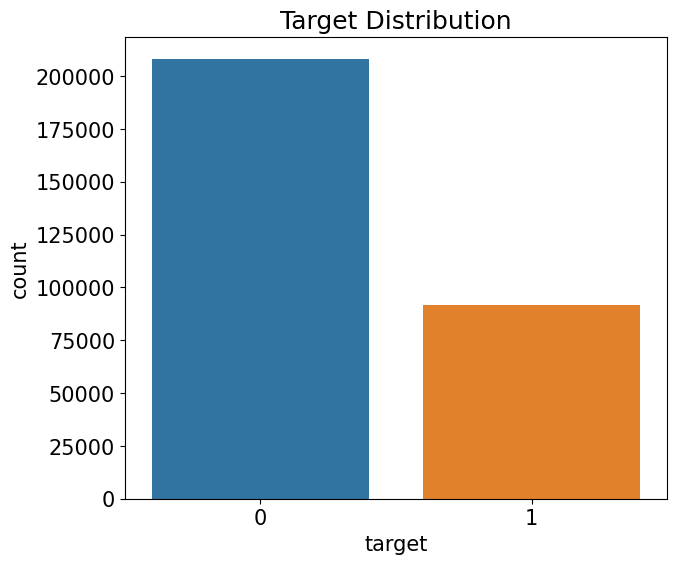

In [247]:
# 카운트플롯으로 타깃값 0,1 의 개수르 파악해보기
# 카운트플롯은 범주형 데이터의 개수를 확인할 때 주로 사용 (보통은 양성(타깃값1)이 음성에 비해 개수가 적다)

# 팁 : 수치형 데이터의 분포를 파악할 땐 주로 displot()을 사용하고, 범주형 데이터의 분포를 파악할 땐 countplot()을 사용

mpl.rc('font',size =15)  # 폰트 크기 설정
plt.figure(figsize= (7,6))# figure 크기 설정

# 타깃값 분포 카운트 플롯
ax = sns.countplot(x='target', data= train)
ax.set_title("Target Distribution")


In [248]:
# 각 값의 비율을 그래프 상단에 표시하면  더 유용할 듯
# 그러기 위해선 글자를 쓸 위치를 구해야 함
# ax.patches는 ax축을 구성하는 그래프 도형 객체 모두를 담은 리스트

print(ax.patches)
ax.patches[0]

<Axes.ArtistList of 2 patches>


In [249]:
ax.patches[1]

In [250]:
# 막대 도형 두개가 그려졌기 떄문에 사각형 객체 두개가 저장됨

In [251]:
# 타깃값 비율을 포시할 위치를 찾아야 함
# 위치를 구하기 위해 사각형의 높이, 너비, 왼쪽 테두리의 x축 위치를 구해보자

rectangle = ax.patches[0]  # 첫번쨰 Rectangle 객체
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())

사각형 높이: 208236.0
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


In [252]:
print("텍스트 위치의 x좌표: ", rectangle.get_x() +rectangle.get_width()/2.0)
print("텍스트 위치의 y좌표: ", rectangle.get_height() + len(train)* 0.001)

텍스트 위치의 x좌표:  0.0
텍스트 위치의 y좌표:  208536.0


Text(0.5, 1.0, 'Target Distribution')

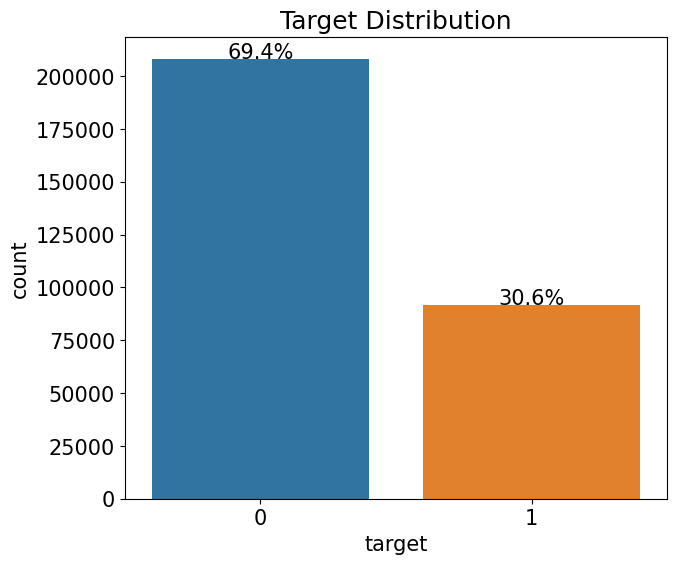

In [253]:
# 비율을 위에 둔 그리프 그리기

def write_percent(ax, total_size):
  '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표지'''
  for patch in ax.patches :
    height = patch.get_height()    # 도형 높이 (데이터 개수)
    width = patch.get_width()      # 도형 너비
    left_coord = patch.get_x()     # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size*100# 타깃 값 비율

    #(x, y) 좌표에 텍스트 입력
    ax.text(x=left_coord + width/2.0,        # x축 위치
            y = height + total_size * 0.001, # y축 위치
            s=f'{percent:1.1f}%',            # 입력 텍스트
            ha = 'center')                   # 가운데 정렬

plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data = train)
write_percent(ax, len(train))   # 비율 표시
ax.set_title("Target Distribution")

In [254]:
# 각 비율이 7대3 으로 의미파악하기에 유용한 그래프

###2.2.2이진 피처 분포

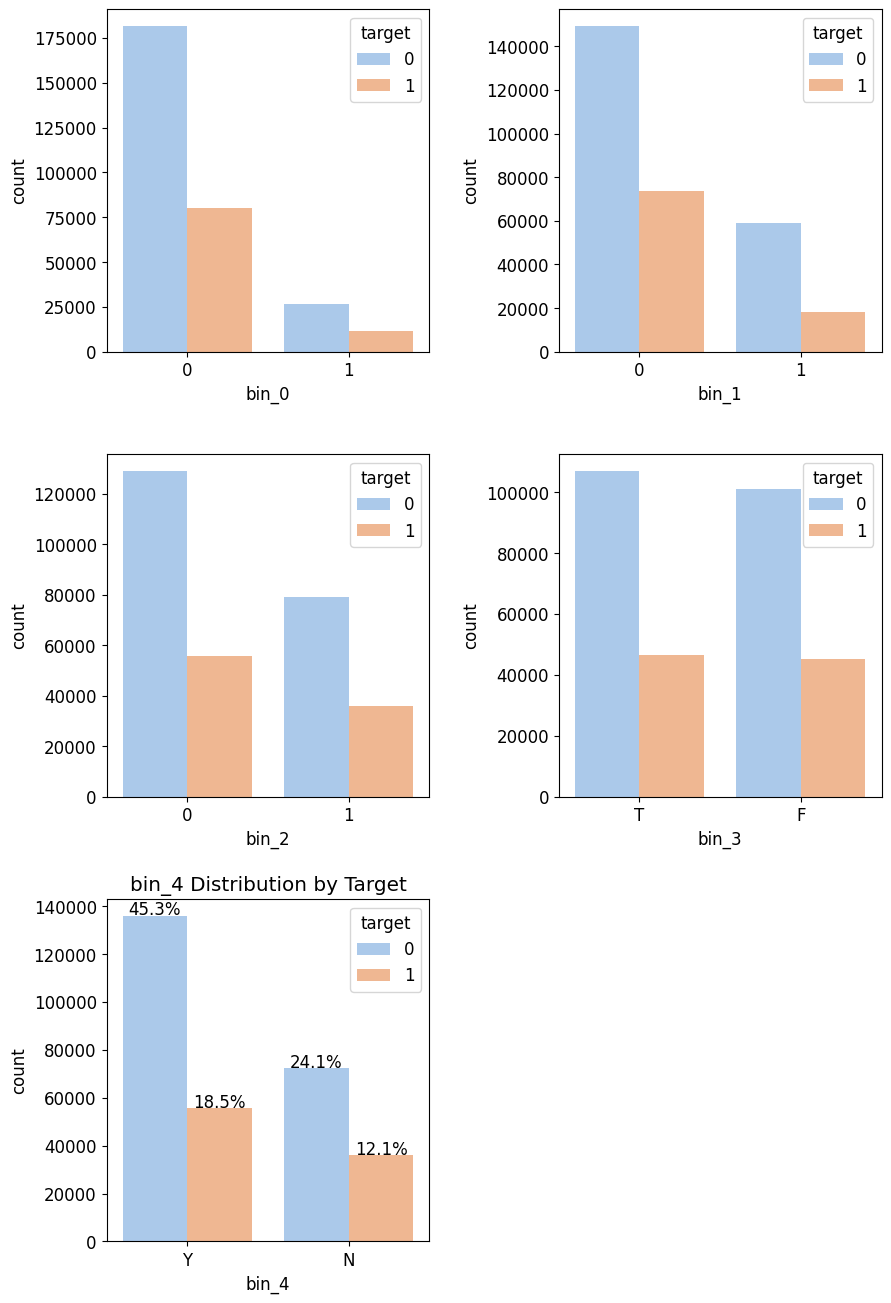

In [255]:
import matplotlib.gridspec as gridspec   # 여러 그래프를 격자 형태로 배치

# 3행 2열 틀(figure) 준비
mpl.rc('font',size = 12)
grid = gridspec.GridSpec(3, 2)        # 그래프(서브플롯)를 2행 2열로 배치
plt.figure(figsize=(10, 16))          # 전체 figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 서브플롯 그리기
bin_features = ['bin_0','bin_1','bin_2','bin_3','bin_4']     # 피처 목록

for idx,feature in enumerate(bin_features) :
  ax = plt.subplot(grid[idx])

  # ax축에 타깃값 분포 카운트플롯 그리기
  sns.countplot(x= feature,
                data= train,
                hue= 'target',
                palette= 'pastel',       # 그래프 색상 설정
                ax= ax)

ax.set_title(f'{feature} Distribution by Target')    # 그래프 제목 설정
write_percent(ax, len(train))          # 비율 표시

###2.2.3명목형 피처 분포

In [256]:
# nom_5~9피처는 고윳값 개수가 많고 의미를 알 수 없는 문자열이 입력 되있어 nom_0~4까지만 시각화

In [257]:
# nom1~4피처는 고윳값별로 타깃 값 1비율이 서로 다르므로 '타깃값에 대한 예측 능력이 있다'고 판단하고 원핫 인코딩
# nom5~9피처는 고윳값이 많지만 의미가 있다고 판단하고 원핫 인코딩해줄것

In [258]:
# 그래프 그리는 순서:
  # 1. 교차분석표 생성 함수 만들기
  # 2. 포인트플롯 생성 함수 만들기
  # 3. 피처 분포도 및 포인트플롯 생성 함수 만들기


In [259]:
# 1. 교차분석표 생성 함수 만들기

# 교차분석표는 범주형 데이터 2개를 비교 분석하는데 사용하는 표 -> 명목형 피처와 타깃값 비교 분석 후 그래프
# 판다스의 crosstab()함수 이용해 교차분석표 만듬

# nom_0와 타깃값인 target간 교차분석표를 만들어 보자

pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [260]:
# 위표에서 개수를 그대로 나타내기보단 비율로 표현하면 한눈에 보기 쉬울듯
# normalize 파리미터를 추가해 정규화 (normalize 파라미터에 'index'를 전달하면 인덱스를 기준으로 정규화 한다)
# 비율이기 떄문에 두값을 더하면 1이여서 백분율로 표한하기 위해 100을 곱해줌

crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [261]:
# 현재 인덱스가 피처이름(nom_0)인데 이를 열로 가져와야 하기 때문에 인덱스 제 설정을 해야함
# 피처이름을 열로 가져오는 이유는 열에 있어야 그래프를 그리기 편하기 때문이다

crosstab = crosstab.reset_index()
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [262]:
# 교차분석이 계속 필요해서 함수로 만들어 놓기

def get_crosstab(df, feature):
  crosstab = pd.crosstab(df[feature], df['target'], normalize= 'index')*100
  crosstab = crosstab.reset_index()
  return crosstab

In [263]:
# 그래프에 타깃값 1비율을 나타내야 하므로 교차분석표에서 타깃값이 1일 비율만 가져오기
crosstab[1]

0    24.179024
1    32.714522
2    35.105173
Name: 1, dtype: float64

In [264]:
# 2. 포인트플롯 생성 함수 만들기
# 교차분석표를 사용하여 타깃값 1의 비율을 나타내는 포인트 플롯을 그리는 함수 만들기
# 함수 이름은 plot_pointplot()이며 세 파라미터를 받음
  # 1. ax : 포인트플롯을 그릴 축
  # 2. feature : 포인트플롯으로 그릴 피처
  # 3. crosstab : 교차분석표

# plot_pointplot()은 이미 카운트플롯이 그려진 축에 포인트플롯을 중복으로 그려준다

def plot_pointplot(ax, feature, crosstab):
  ax2 = ax.twinx()   # x축을 공유하고 y축은 공유하지 않는 새로운 축 생성

  # 새로운 축에 포인트플롯 그리기
  ax2 = sns.pointplot(x=feature, y=1, data = crosstab,
                      order= crosstab[feature].values,    # 포인트플롯 순서
                      color = 'black'            # 포인트플롯 색상
                      )              # 범례 미표시

  ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)   # y축 범위 설정
  ax2.set_ylabel("Target 1 ratio(%)")

In [265]:
# 3. 피처 분포도 및 타깃값 1의 비율 포인트플롯 생성 함수 만들기

# get_crosstab()과 plot_pointplot()함수를 이용해 최종 그래프를 그리는 함수 만들어보기

def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size=(15,20)):
  plt.figure(figsize=size)         # 전체 Figure 크기 설정
  grid = gridspec.GridSpec(num_rows, num_cols)      # 서브플롯 배치
  plt.subplots_adjust(wspace=0.45, hspace= 0.3)     # 서브플롯 좌우/상하 여백 설정

  for idx, feature in enumerate(features):
    ax = plt.subplot(grid[idx])
    crosstab = get_crosstab(df, feature)      # 교차분석표 생성

    #  ax축에 타깃값 분포 카운트 플롯 구하기
    sns.countplot(x= feature, data= df,
                  order = crosstab[feature].values,
                  color = 'skyblue',
                  ax = ax)

    write_percent(ax,len(df))         # 비율 표시

    plot_pointplot(ax, feature, crosstab)         # 포인트플롯 그리기

    ax.set_title(f'{feature} Distribution')       # 그래프 제목 설정



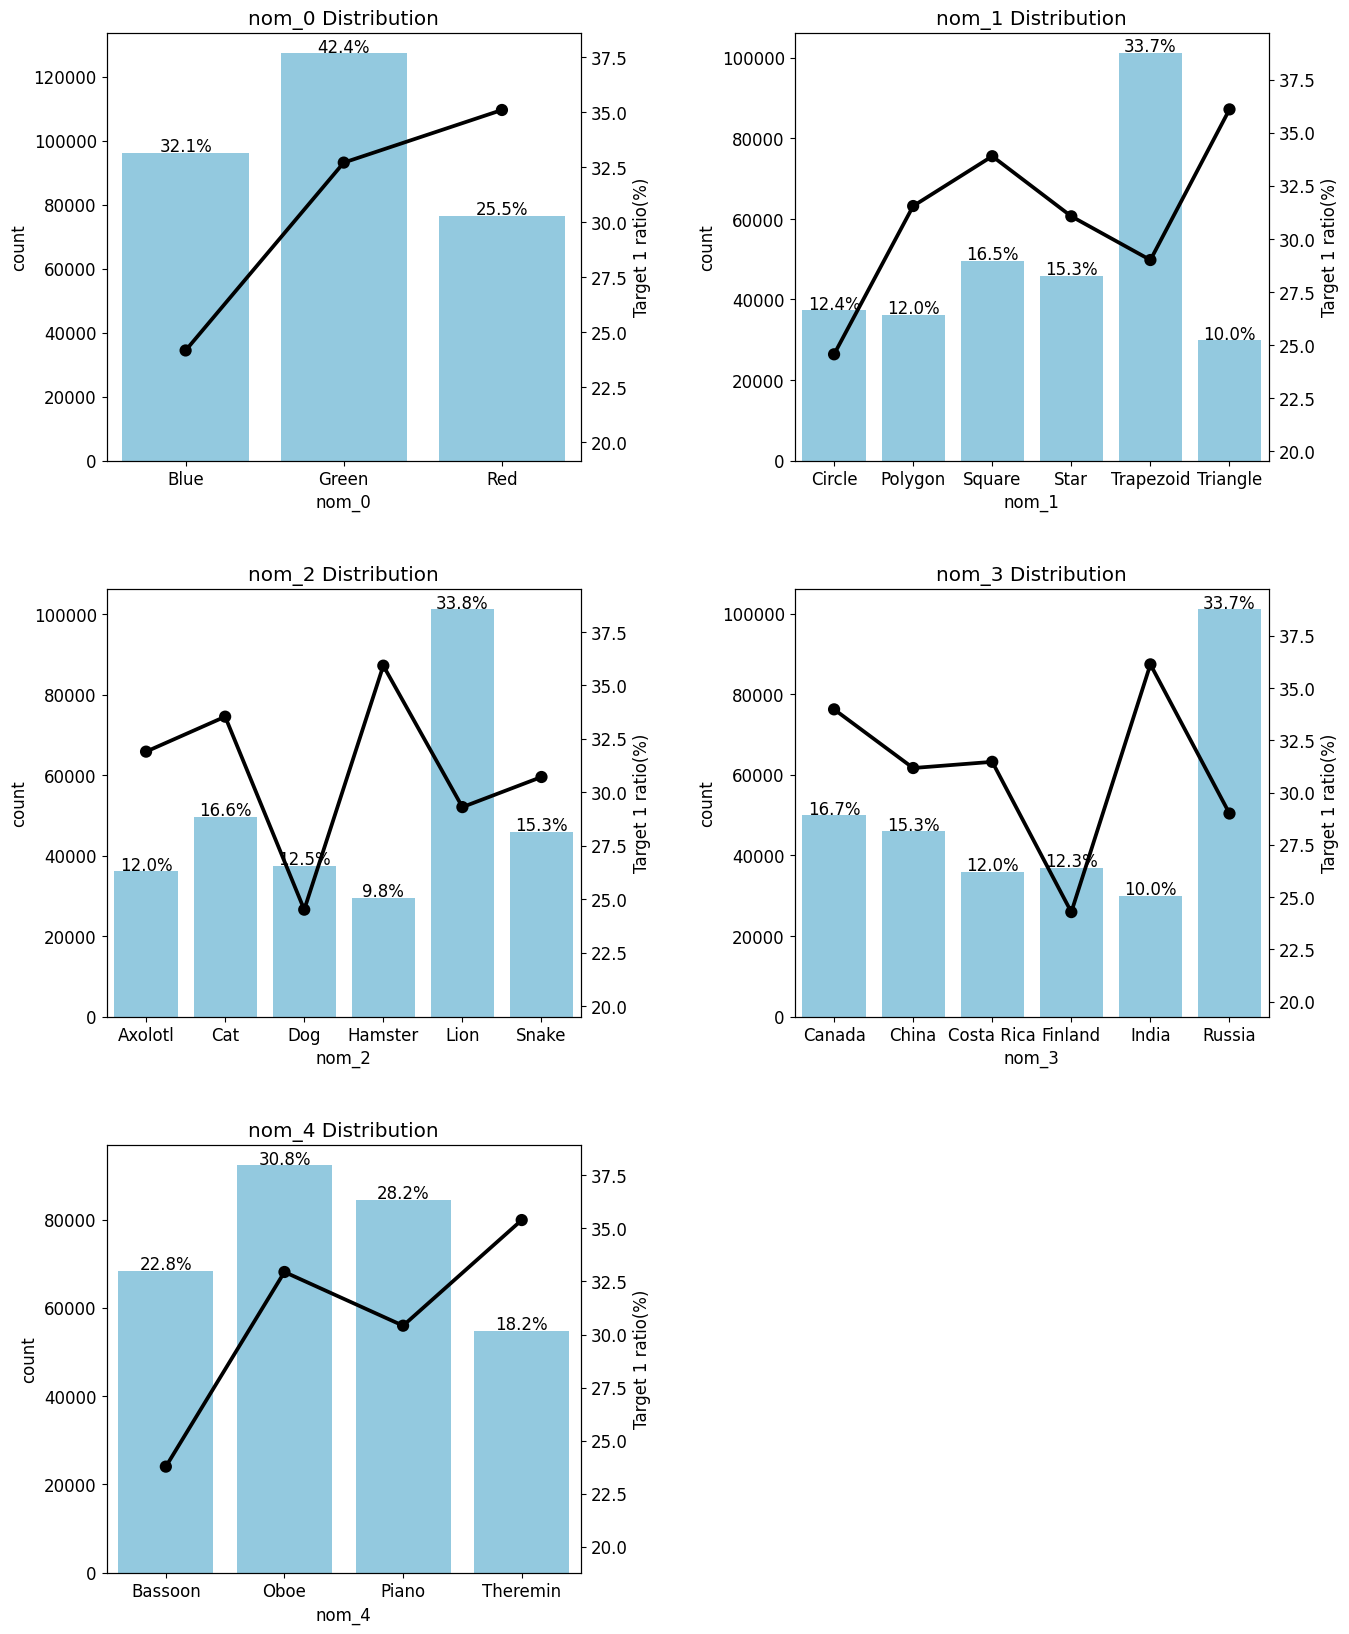

In [266]:
nom_features = ['nom_0','nom_1','nom_2','nom_3','nom_4']       # 명목형 피처
plot_cat_dist_with_true_ratio(train, nom_features, num_rows= 3, num_cols= 2)

###2.2.4수치형 피처 분포

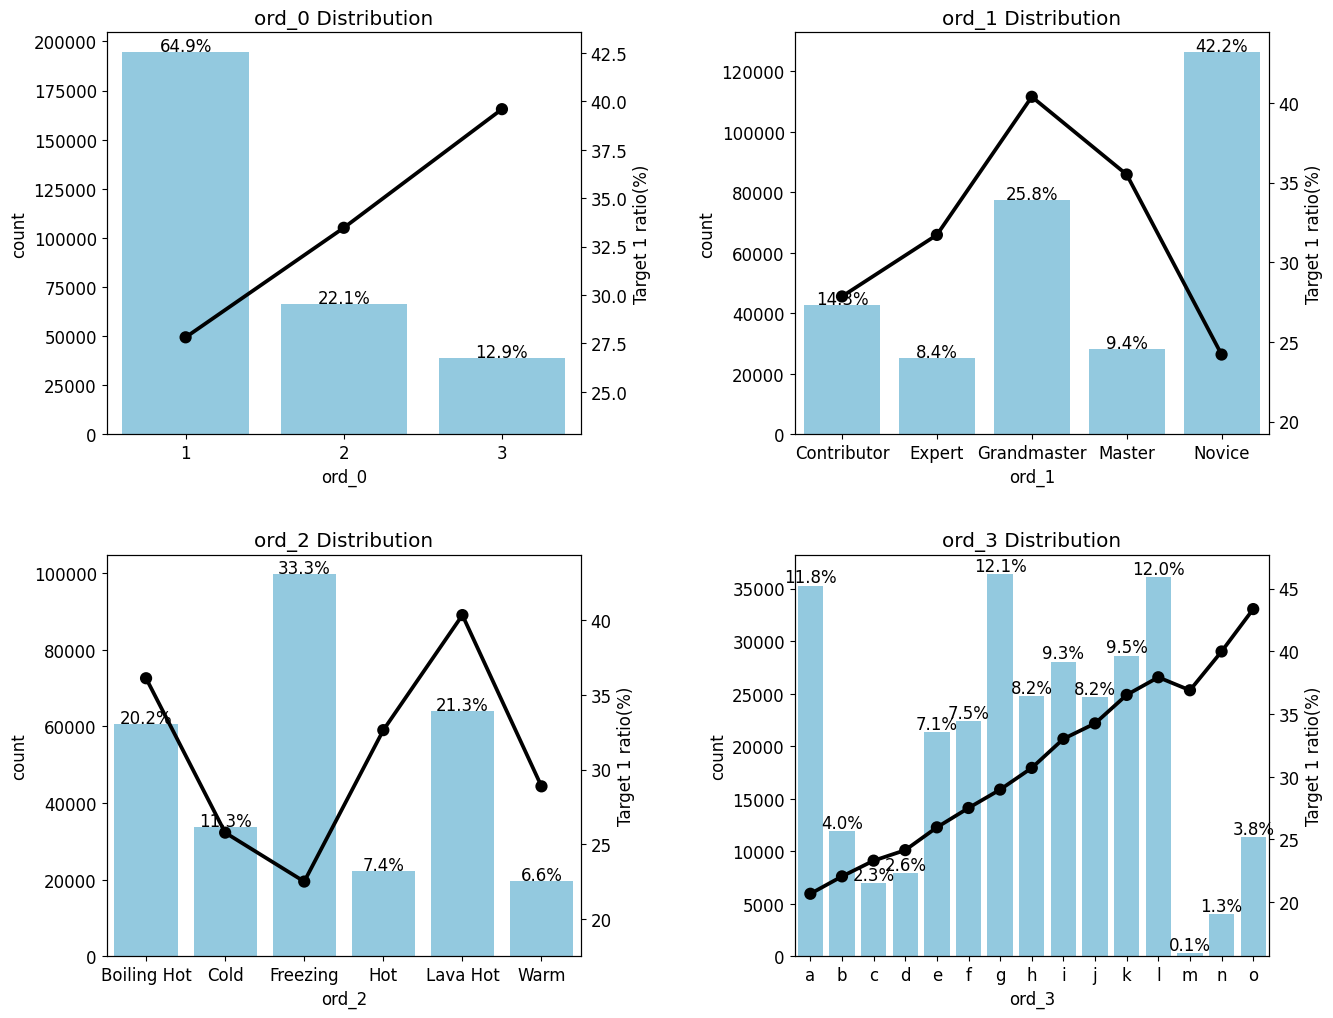

In [267]:
# plot_cat_dist_with_true_ratio() 함수를 사용해서 분포도 그림
# ord_0~3 까진 피처수가 15개 미만이라 2행 2열로 나타냄
# ord_4~5는 피처수가 많아서 2행 1열로 그래프를 따로 나타냄
# 먼저 ord_0~3 그려봄

ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3']    # 순서형 피처
plot_cat_dist_with_true_ratio(train, ord_features, num_rows= 2, num_cols= 2, size=(15,12))

In [268]:
# 그런데 ord_1~2는 피처 값들의 순서가 정렬인 안됨
# CategoricalDtype()을 이용해 피처 순서 지정할 수 있음

from pandas.api.types import CategoricalDtype

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 순서를 지정한 범주형 데이터 타입

ord_1_dtype = CategoricalDtype(categories = ord_1_value, ordered = True)
ord_2_dtype = CategoricalDtype(categories = ord_2_value, ordered = True)

# 데이터 타입 변경

train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

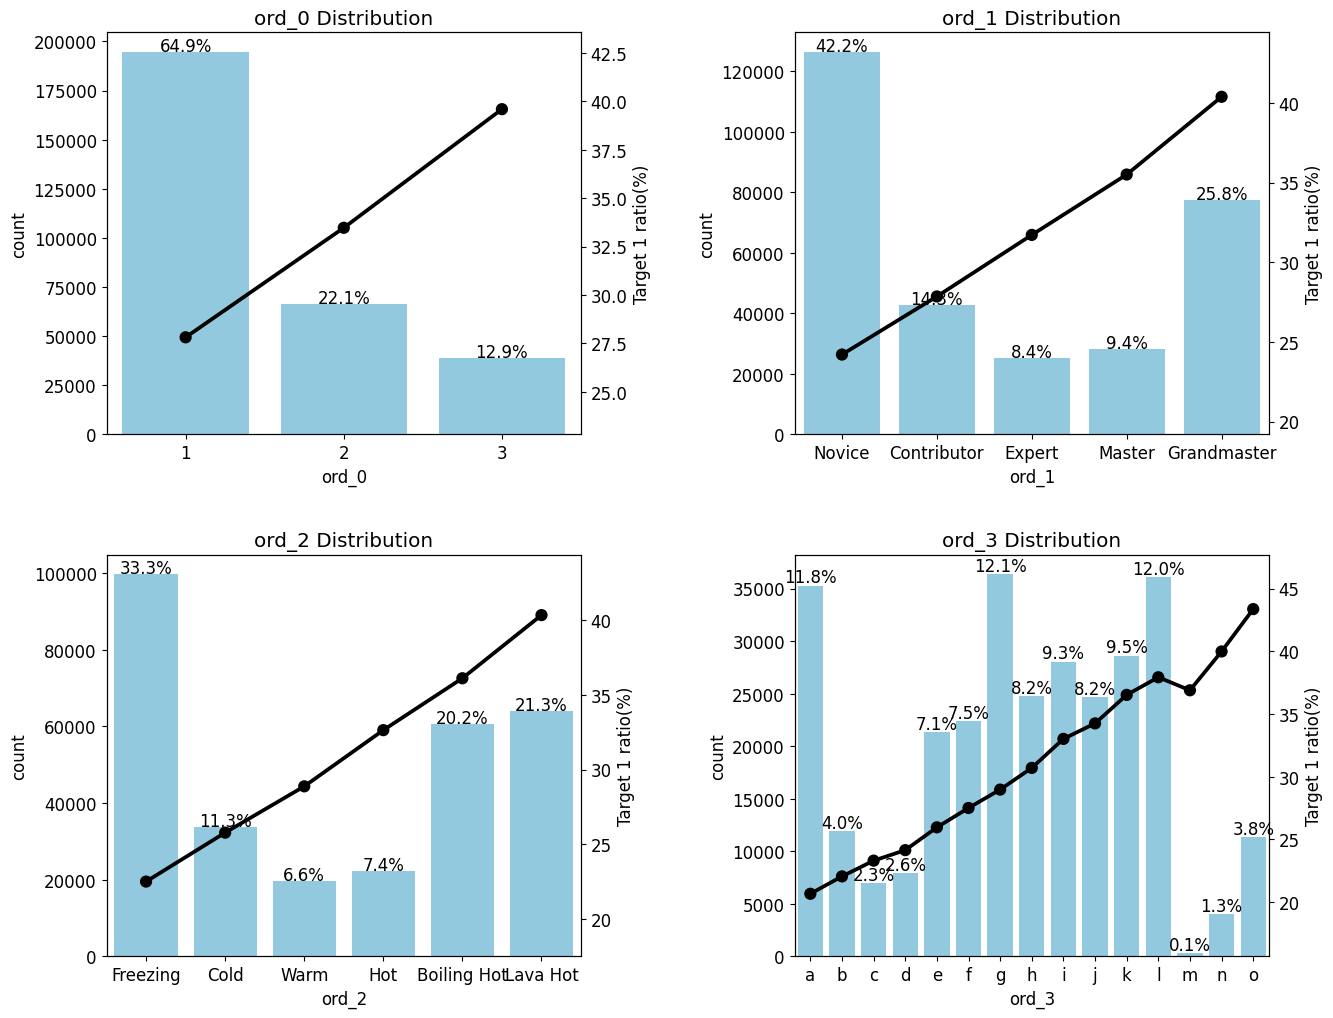

In [269]:
# 정렬된 데이터를 활용해 다시 그래프 그림

plot_cat_dist_with_true_ratio(train, ord_features, num_rows= 2, num_cols= 2, size=(15,12))

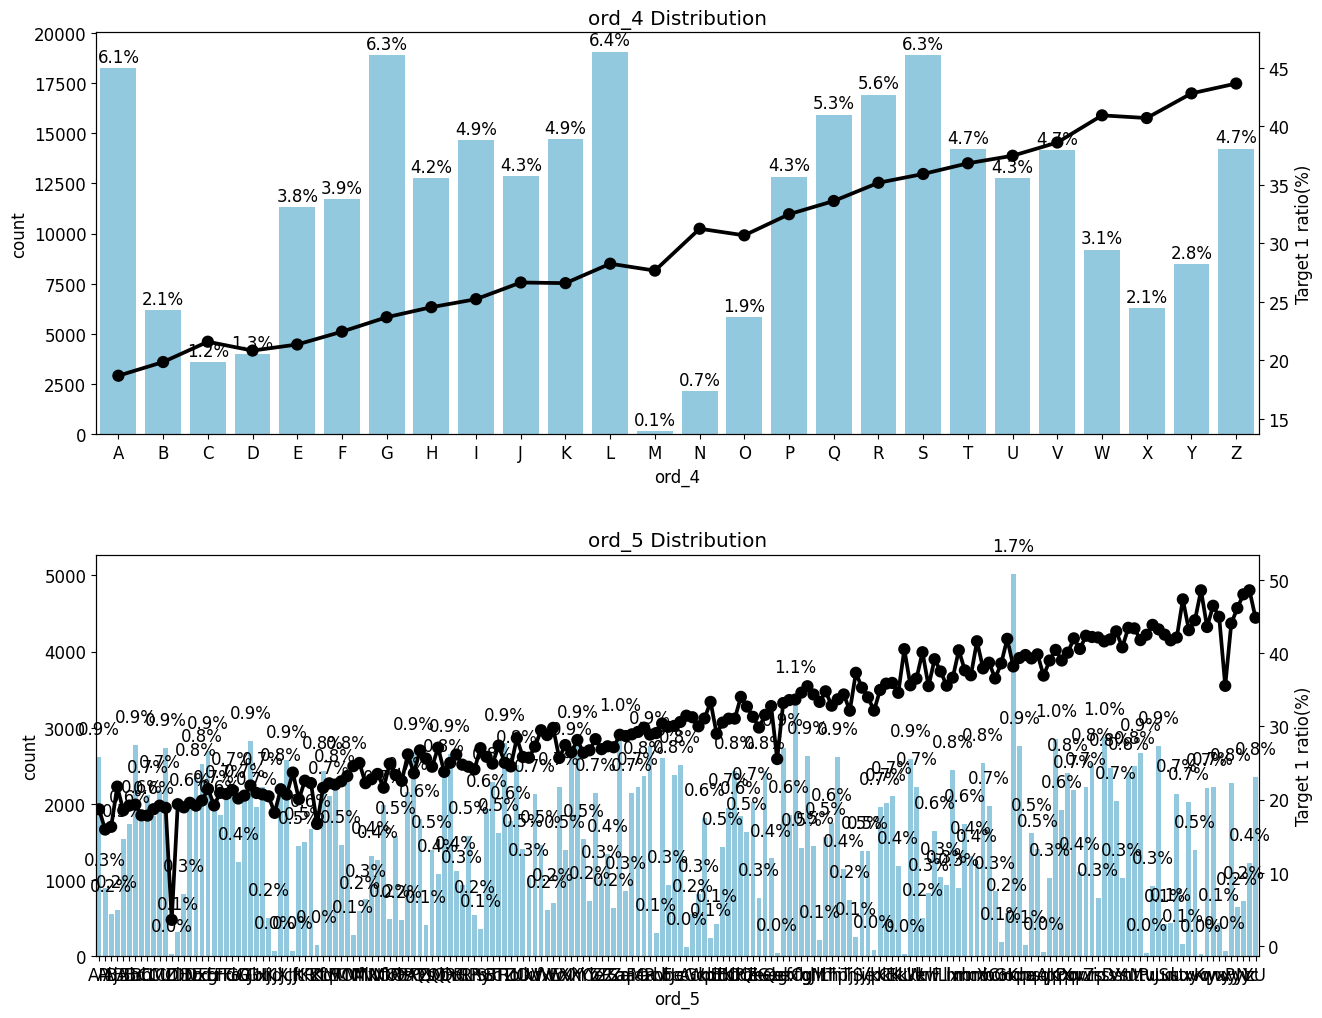

In [270]:
# ord_4~5 그래프 그려보기

plot_cat_dist_with_true_ratio(train, ['ord_4','ord_5'], num_rows= 2, num_cols= 1, size=(15,12))

In [271]:
# ord_5는 고윳값이 너무 많아 x라벨이 겹치지만 타깃값 1비율의 전체적인 양상 보는데 지장없음

In [272]:
# 이상으로 순서형 피처 모두 고윳값 순서에 따라 타깃값이 1인 비율이 증가한다고 알 수 있다

###2.2.5날짜 피처 분포

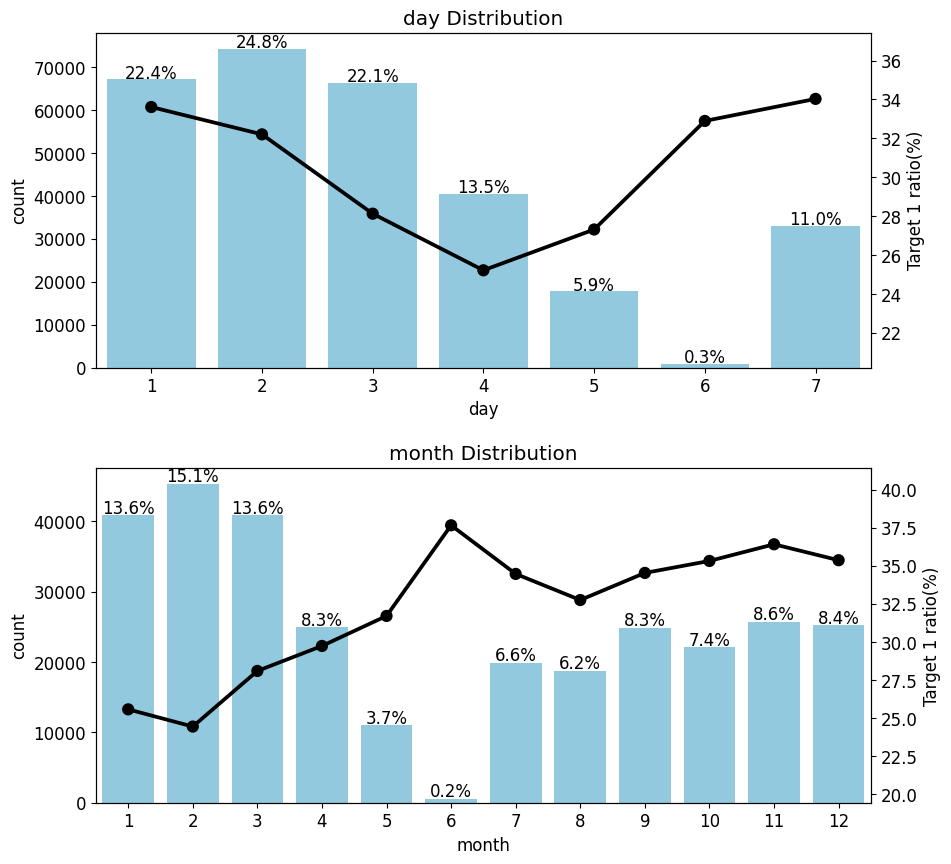

In [273]:
date_features = ['day', 'month']
plot_cat_dist_with_true_ratio(train, date_features, num_rows= 2, num_cols= 1, size=(10,10))

In [274]:
# 제거할 피처 없음

In [275]:
# 달을 예를 들어 1월과 2월의 거리와 12월과 1월의 거리가 같은데 컴퓨터는 인식을 못하기 때문에 이것을 해결 하는 방법으로 삼각함수를 사용하여 인코딩 할 수 있다
# 하지만 데이터가 그리 크지 않아서 삼각함수 인코딩이 제대로 효과를 발휘하지 못할 가능성이 높음.
# 똑같이 원-핫 인코딩 하겠음

#3.베이스라인 모델

In [276]:
# 이번 절에서는 모든 피처를 원핫 인코딩한 뒤, 로지스틱 회귀 모델로 베이스라인을 만들어 보자
# 전체 프로세스는 6장과 같다

# 모든 피처를 원핫인코딩 하면 되서 피처 엔지니어링도 단순 하고 사이킷런이 제공하는 모델을 사용할 것이기 대문에 코드가 간단할 예정

In [277]:
# 데이터 불러오기

train = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/train.csv', index_col = 'id')
test = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/test.csv', index_col = 'id')
submission = pd.read_csv('/content/drive/MyDrive/자료/7장. 범주형 데이터 이진분류/sample_submission.csv', index_col = 'id')

##3.1.피처 엔지니어링

###3.1.1.데이터 합치기

In [278]:
# 머신러닝 모델은 문자를 이해하지 못해 숫자로 바꿔줘야하는데 훈련데이터와 테스트데이터에 동일한 인코딩을 적용하기 위해서 편의상 둘을 합침
# 피처와 타깃값은 따로 모델링 해야하기 때문에 타깃값 제거

In [279]:
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis= 1)
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


###3.1.2.원-핫 인코딩

In [280]:
# 모든 피처 원-핫 인코딩

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

###3.1.3.데이터 나누기

In [281]:
# 다시 훈련, 테스트 데이터 나누기

# concat()을 써서 합쳤어서 행번호를 기준으로 다시 나눔

num_train = len(train)   #훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [282]:
# 훈련 데이터에서 일부를 검증 데이터로 나눔
# 이유는 모델의 성능을 검증하는데 사용

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y,test_size=0.1,
                                                      stratify=y,random_state=10)

##3.2.모델 훈련

In [283]:
# 이제 모델을 생성한 뒤 앞에서 준비한 데이터를 사용하여 훈련해보겠음
# 로지스틱 회귀 모델(선형 회귀 방식을 응용해 분류를 수행하는)를 사용

from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter = 1000, random_state= 42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [284]:
# 위 모델에 대해 설명하자면
  # 1. max_iter : 모델의 회귀 계수를 업데이트하는 반복 횟수, 모델 훈련 시 회귀 계수를 업데이트 하면서 훈련하는데, 이때 업데이트를 몇번 할지를 정함
  # 2. random_state : 값을 지정하면 어려번 실행해도 매번 똑같은 결과가 나옴. 아무 값이나 지정해도 상관없음

##3.3.모델 성능 검증

In [285]:
# 사이킷런은 타깃값 예측 메서드를 두가지 제공
  # 1.predict() : 타깃값 자체( 0이냐 1이냐)를 예측
  # 2.predict_proba() : 타깃값의 확률(0일확률과 1일 확률)을 나타냄

# 확률을 알아보기 위해 predict_proba()함수 사용

logistic_model.predict_proba(X_valid)

array([[0.23273481, 0.76726519],
       [0.91407038, 0.08592962],
       [0.83036873, 0.16963127],
       ...,
       [0.24858679, 0.75141321],
       [0.49420831, 0.50579169],
       [0.95659243, 0.04340757]])

In [286]:
# 위 결과는 첫번째 열은 타깃값 0일확률이고 두번째 열은 타깃값 1일 확률을 나타냄

In [287]:
# 다음은 predict()함수 사용해 보겠음

logistic_model.predict(X_valid)

array([1, 0, 0, ..., 1, 1, 0])

In [288]:
# 목표는 타깃값이 1인 확률을 구하는 것이기 때문에 predict_proba()함수 사용해서 나오는 두번째 열을 타깃 예측값으로 사용함

y_valid_preds = logistic_model.predict_proba(X_valid)[:,1]

In [289]:
# y_valid_preds와 y_valid를 평가지표인 ROC AUC를 이용해 모델 성능을 검증해보자
#  ROC AUC 점수는 사이킷런의 roc_auc_score()함수를 이용해서 쉽게 구할 수 있다

from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc: 4f}')

검증 데이터 ROC AUC :  0.796506


##3.4.예측 및 결과 제출

In [290]:
# 이제 테스트 데이터를 활용해 타깃값이 1일 확률을 예측하고 결과를 제출해보자

y_preds = logistic_model.predict_proba(X_test)[:,1]

In [291]:
# 제출 파일 만들기

submission['target'] = y_preds
submission.to_csv('submission.csv')

#4.성능 개선1

In [292]:
# 6장에서는 베이스라인 모델과 다른 모델을 사용해 성능을 높였지만
# 이번 7장에서는 베이스라인 모델 자체의 성능을 높여보겠음

In [293]:
# 성능 향상을 위해 3가지 주안점을 두어 모델링 진행
  # 1. 피처 맞춤 인코딩
  # 2. 피처 스케일링
  # 3. 하이퍼파라미터 최적화

##4.1.피처 엔지니어링1 : 피처 맞춤 인코딩

In [294]:
# 특성에 맞게 인코딩 할것
# 순서는 이진, 순서형, 명목형,날짜 피처 순으로 진행

In [295]:
# 짧게 과정 요약
# 데이터 합쳐서 all_data 저장 후 , 이진 피처와 순서형 피처는 적절히 인코딩 해서 all_data에 저장
# 명목형과 날짜 피처는 원-핫 인코딩 해서 행렬로 저장( all_data에 바로 저장 못하는 이유는 원-핫 인코딩 했을때 열 개수가 너무 많아짐)
# 이때 all_data에서 기존의 명목형과 날짜 피처는 삭세
# all_data 와 명목형과 날짜 피처 합치면 끝

###4.1.1데이터 합치기

In [296]:
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis = 1)

###4.1.2이진 피처 인코딩

In [297]:
# bin_0~2 피처는 이미 0과 1로 잘 구성되 있어 따로 인코딩 하지 않음
# bin_3과4 피처는 각각 T와 F, Y와 N이라는 문자로 구성 되있어 각각 0과 1로 바꿔줌
# 이때 판다스 map() 사용

all_data['bin_3'] = all_data['bin_3'].map({'F':0,'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0,'Y':1})

###4.1.3순서형 피처 인코딩

In [298]:
# 1. ord_0피처는 이무 숫자로 구성돼 인코딩 안해도 댐
# 2. ord_1~2 피처는 순서를 정해서 인코딩
# 3. ord_3~5 피처는 알파벳 순서대로 인코딩 해줌

In [299]:
# 2. ord_1~2 피처는 순서를 정해서 인코딩

# map()을 이용해 인코딩

ord1dict= {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict= {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

In [300]:
# 3. ord_3~5 피처는 알파벳 순서대로 인코딩 해줌

# 사이킷런의 OrdinalEncoder를 사용

# 물론 map() 함수를 사용해서 해도 되지만 고윳값이 너무 많아서 사용안함

from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder()

# ordinal 인코딩 적용

all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

# 피처별 인코딩 순서 출력

for feature, categories in zip(ord_345, ord_encoder.categories_):
  print(feature)
  print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

In [301]:
#위 ord_encoder.categories_는 인코딩이 잘 적용됬는지 보여주는 것

# 인코딩 된지 확인
all_data['ord_3']

id
0          7.0
1          0.0
2          7.0
3          8.0
4          0.0
          ... 
499995     9.0
499996     5.0
499997     6.0
499998     6.0
499999    11.0
Name: ord_3, Length: 500000, dtype: float64

###4.1.4.명복형 피처 인코딩

In [302]:
# 명목형 피처는 순서를 무시해도 되게 때문에 원-핫 인코딩 적용
# 먼저 지능형 리스트를 활용해 명목형 피처 리스트를 만듬

nom_features = ["nom_" + str(i) for i in range(10)]     # 한줄로 코드 완성(지능형 리스트)

In [303]:
# 이 명목형 피처를 원-핫 인코딩해 별도 행렬에 저장하고
# all_data에서 명목형 피처 삭제
# 이유는 열 개수가 늘어나서 all_data에서 바로 인코딩 불가

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()

encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

In [304]:
# 원-핫 인코딩 후 명목형 피처의 행렬 크기가 (50000*16276). 즉 16276개의 열이 생성됨

In [305]:
# ** 희소행렬과 COO, CRS 형식 **
## 희소 행렬 : 대부분 값이 0으로 채워지는 행렬
## 말집 행렬 : 대부분 값이 0 이 아닌 다른값으로 채워짐

## 원-핫 인코딩을 적용하면 희소 행렬이 만들어짐.
## 하지만 메모리 낭비가 심함

## 이런 문제를 해결하기 위해 행렬 형식을 바꿔줌(COO, CRS로)
## 이중에도 CRS 형식으로 표현 하면 메모리 낭비를 더 줄이고 연산도 더 빠름
## 그래서 일반적으로 CRS형식을 더 많이 씀

In [306]:
# 명목형 피처를 원-핫 핫코딩한 결과를 encoded_nom_matrix에 저장해놨는데 이는 CRS형식의 행렬이다

# 마지막으로 all_data에서 명목형 피처 삭제

all_data = all_data.drop(nom_features, axis = 1)

###4.1.5.날짜 피처 인코딩

In [307]:
# 원-핫 인코딩 적용

date_features = ['day','month']

encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])

all_data = all_data.drop(date_features, axis = 1)

encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

##4.2.피처 엔지니어링2 : 피처 스케일링


In [308]:
# 서로 다른 피처들의 값의 범위가 일치하도록 조정하는 작업
# 필요한 이유 : 수치형 피처들의 유효 값 범위가 서로 다르면 훈련이 제대로 안될 수 있기 때문
# 앞에서 이진, 명목형, 날짜 피처를 모두 0과 1로 인코딩 했음
# 하지만 순서형 피처는 여러 값을 가지고 있어서 0~1 사이가 되도록 스케일링 해줄 것

###4.2.1순서형 피처 스케일링

In [309]:
# 다른 피처들과 범위를 맞추기 위해 순서형 피처에 min-max 정규화를 적용하겠음
# min-max 정규화는 피처 값의 범위를 0~1로 조절함

from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)]

all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

###4.2.2.인코딩 및 스케일링된 피처 합치기

In [310]:
# 다 합쳐야 하는데 all_data는 데이터프레임 형태고
# encoded_date_matrix 와 encoded_nom_matrix 는 CSR 형식의 행렬이다
# 그래서 all_data를 CSR 형식의 행렬로 만든 후 합치기

# 사이파이가 제공하는 csr_matrix()는 전달받은 데이터를 CSR 형식으로 바꿔줌

from scipy import sparse

# 인코딩 및 스케일링 된 피처 합치기

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),       # hstack : 수직으로 합치기
                               encoded_nom_matrix,
                               encoded_date_matrix],
                              format = 'csr')         # 합친 결과를 CSR 형식으로 반환

In [311]:
# 데이터 확인

all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

In [312]:
# 위 결과 500,000 행 16,306열인데 이정도 크기를 데이터 프레임 형태로 처리하면 메모리 낭비가 심하고 훈련 속도 떨어짐
# 그래서 CSR로 처리

###4.2.3.데이터 나누기

In [313]:
num_train = len(train)   #훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [314]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y,test_size=0.1,
                                                      stratify=y,random_state=10)

##4.3.하이퍼파라미터 최적화

In [315]:
# 6장에서 배운 그리드서치를 활용해 로지스틱 회귀 모델의 하이퍼파라미터를 최적화 해보겠다
# 탐색할 하이퍼파라미터는 C와 max_iter이다
# C는 규제 강도를 조절하는 파라미터로, 값이 작을수록 규제강도가 세짐

In [319]:
# 모델을 생성하고 평가지표를 ROC AUC로 지정해 그리드 서치를 수행해 보겠다

# 첫 줄에 %%time 을 하여 해당 셀 실행 후 소요시간을 출력 받음

%%time

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

# 하이퍼파라미터 값목록

lr_params = {"C":[0.1,0,.125,0.2],'max_iter':[800,900,1000],
             'solver':['liblinear'],'random_state':[42]}

# 그리드서치 객체 생성

gridsearch_logistic_model = GridSearchCV(estimator =logistic_model,
                                         param_grid = lr_params,
                                         scoring = 'roc_auc',
                                         cv=5)

# 그리드 서치 수행

gridsearch_logistic_model.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", gridsearch_logistic_model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklear

최적 하이퍼파라미터:  {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
CPU times: user 11min 23s, sys: 7min 40s, total: 19min 3s
Wall time: 15min 3s


##4.4.모델 성능 검증

In [320]:
# 검증 데이터를 통해 개선 됬는지 확인하기
# 먼저 검증 데이터로 타깃 예측값을 구하자

y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:,1]

In [321]:
# 이어서 검증 데이터 ROC AUC를 구해보자

from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8039


In [322]:
# ROC AUC가 0.8045이다. 베이스라인 모델보다 0.008만큼 향상되었다

##4.5.예측 및 결과 제출

In [ ]:
# 제출 파일을 만들어 커밋 후 제출

# 타깃값 1일 확률 예측

y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]

# 제출 파일 생성

submission['target'] = y_preds
submission.to.csv('submission.csv')

In [325]:
# ****** 팁 *************
# 검증 데이터로 훈련 데이터의 10% 사용했는데 검증하는데만 사용하지 말고 훈련시킬때 훈련데이터로도 넣으면 더 좋은 결과가 나올 수도 있음